# 📊 Sistema de Informação de Mortalidade - Banco de Dados Relacional

### Informações dos Alunos

- **Curso**: Programa de Pós-Graduação em Computação Aplicada - UnB
- **Disciplina**: Fundamentos de Banco de Dados
- **Data**: 21 de fevereiro de 2025


**Autores**
-  Ebenezer Andrade da Silva | **Matricula**: 241134715 
- Geison de Souza Oliveira | **Matricula**: 242105843
---

## Informações do Projeto  

Informações adicionais sobre este projeto podem ser encontradas no repositório do GitHub:  

**[FDB - Repositório Oficial](https://github.com/ebenezerandrade1/FDB)** 

##  Introdução

Este projeto tem como objetivo a criação de um **banco de dados relacional** para armazenar e analisar informações sobre óbitos, utilizando dados extraídos do Sistema de Informação de Mortalidade (SIM). A implementação inclui **ETL**, **views**, **procedures**, **triggers** e diversas consultas SQL para explorar os dados.

## Modelo de Dados Relacional

O banco de dados foi estruturado seguindo os princípios da **modelagem relacional**, garantindo **integridade referencial** e **normalização**. O esquema contém as seguintes tabelas:

- **`obitos`** - Registros dos óbitos com detalhes como local, hora, causa da morte, entre outros.
- **`localizacoes`** - Municípios e estados onde os óbitos ocorreram.
- **`causas`** - Código CID e descrição das causas de morte.


Diagrama do Modelo Relacional:

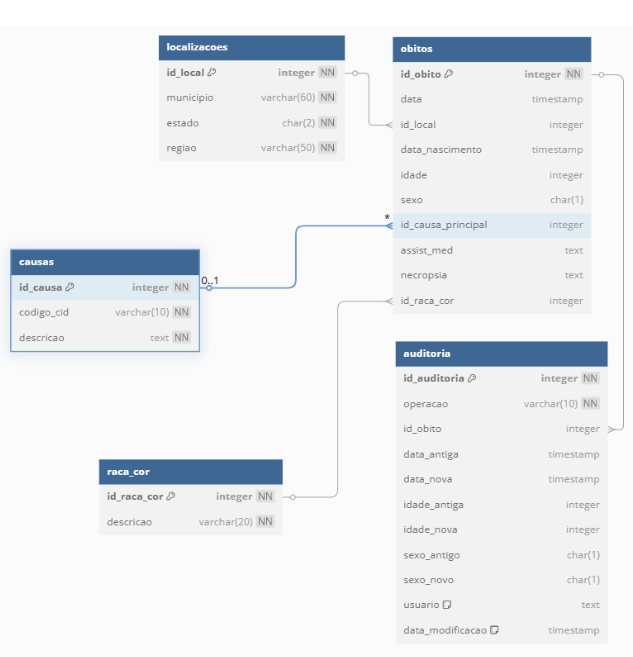

##  Script SQL - Criação do Banco de Dados

O banco de dados foi criado utilizando **PostgreSQL**.  
O script SQL para criação das tabelas está disponível no arquivo:  

**[tabelas.sql - Clique aqui para acessar](https://github.com/ebenezerandrade1/FDB/blob/main/scripts/tabelas.sql)** 



# Processo ETL - Extração, Transformação e Carga dos Dados  

O processo **ETL (Extract, Transform, Load)** foi desenvolvido para garantir a ingestão eficiente e estruturada dos registros de óbitos no banco de dados **PostgreSQL**.  
A implementação foi realizada utilizando **Python**, empregando as bibliotecas **pandas** e **SQLAlchemy**, para manipulação e inserção dos dados de forma automatizada.  

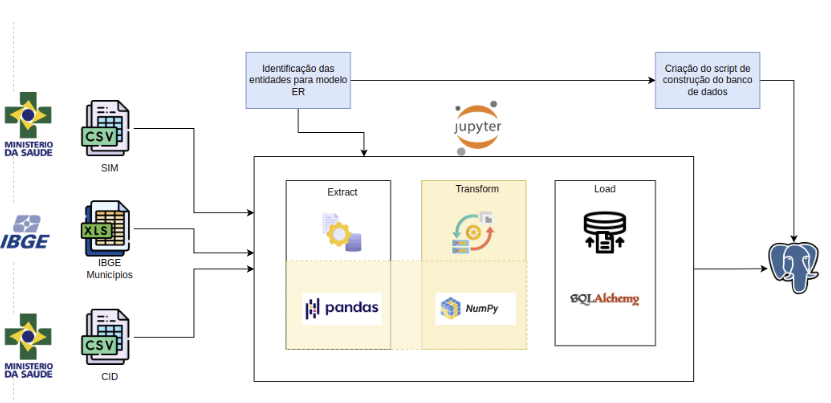


Os pipelines foram desenvolvidos utilizando **Jupyter Notebook** e **Python**, garantindo a automação do processo **ETL** para diferentes conjuntos de dados.  
Os arquivos podem ser acessados nos links abaixo:

- **[📂 Pipeline - Causas](https://github.com/ebenezerandrade1/FDB/blob/main/Pipeline/causas.ipynb)**
- **[📂 Pipeline - Localizações](https://github.com/ebenezerandrade1/FDB/blob/main/Pipeline/localizacoes.ipynb)**
- **[📂 Pipeline - Óbitos](https://github.com/ebenezerandrade1/FDB/blob/main/Pipeline/obitos.ipynb)**  

Cada um desses pipelines realiza **extração, transformação e carga (ETL)** dos respectivos dados, garantindo qualidade e consistência para análises posteriores.

---

## Fases do Processo ETL  

### Extração - Coleta de Dados  
Na primeira etapa do processo, os dados foram extraídos de arquivos **CSV**, os quais continham informações sobre registros de óbitos, municípios e causas de morte. Essa extração foi realizada utilizando **pandas**, possibilitando a leitura e conversão dos arquivos para **DataFrames**, garantindo melhor manipulação dos dados.  

#### **Principais ações na extração:**  
- Importação dos dados a partir de arquivos **CSV**.  
- Leitura eficiente dos arquivos utilizando **pandas**.  
- Estruturação inicial dos dados para facilitar o tratamento.  


### Transformação - Tratamento e Padronização  
Após a extração, os dados passaram por uma série de transformações para garantir **qualidade e integridade** antes da carga no banco de dados.  

#### **Principais ações na transformação:**  
- **Conversão de tipos de dados:** Ajuste de colunas de **datas, números e categorias**.  
- **Tratamento de valores ausentes:** Aplicação de regras para preenchimento ou remoção de registros inconsistentes.  
- **Criação de um dicionário de dados:** Variáveis numéricas que representavam valores categóricos foram convertidas em valores descritivos, aumentando a legibilidade dos dados.  
- **Normalização de IDs:** Ajuste dos códigos de municípios para garantir padronização, incluindo **preenchimento de zeros à esquerda**.  
- **Remoção de registros inválidos:** Exclusão de dados corrompidos ou inconsistentes.  

Essas transformações garantiram que os dados estivessem **limpos e estruturados corretamente** para serem inseridos no banco.


### Carga - Inserção no Banco de Dados  
Por fim, os dados tratados foram **inseridos no banco de dados PostgreSQL**.  
A inserção foi realizada utilizando a biblioteca **SQLAlchemy**, garantindo uma integração eficiente com o banco.  

#### **Principais ações na carga:**  
- **Validação de integridade referencial:**  
  - Antes da inserção, foi realizada uma verificação para garantir que **chaves estrangeiras** existissem na base de dados, prevenindo erros de integridade.  
- **Filtragem de registros inconsistentes:**  
  - Registros cujo `id_local` **não existisse na tabela de municípios** foram descartados da inserção, evitando erros de **Foreign Key Violation**.  
- **Execução otimizada:**  
  - Inserção em lote para maior eficiência na carga dos dados.  

**A cada erro encontrado, o script exibia o `id_local` inexistente** para fins de auditoria e correção posterior.  





##  View

### vw_obitos_detalhado

A VIEW __vw_obitos_detalhado__ traz informações detalhadas dos óbitos, juntando dados das tabelas relacionadas (__raca_cor__, __causas__, __localizacoes__ e __obitos__)

### Script
```sql
CREATE OR REPLACE VIEW vw_obitos_detalhado AS
SELECT 
    o.id_obito,
    o.data AS data_obito,
    o.data_nascimento,
    o.idade,
    o.sexo,
    rc.descricao AS raca_cor,
    c.codigo_cid,
    c.descricao AS causa_morte,
    l.municipio,
    l.estado,
    l.regiao,
    o.assist_med,
    o.necropsia
FROM public.obitos o
LEFT JOIN public.raca_cor rc ON o.id_raca_cor = rc.id_raca_cor
LEFT JOIN public.causas c ON o.id_causa_principal = c.id_causa
LEFT JOIN public.localizacoes l ON o.id_local = l.id_local;
```

### Consulta
```sql
SELECT * FROM vw_obitos_detalhado;
```

### Resutlado

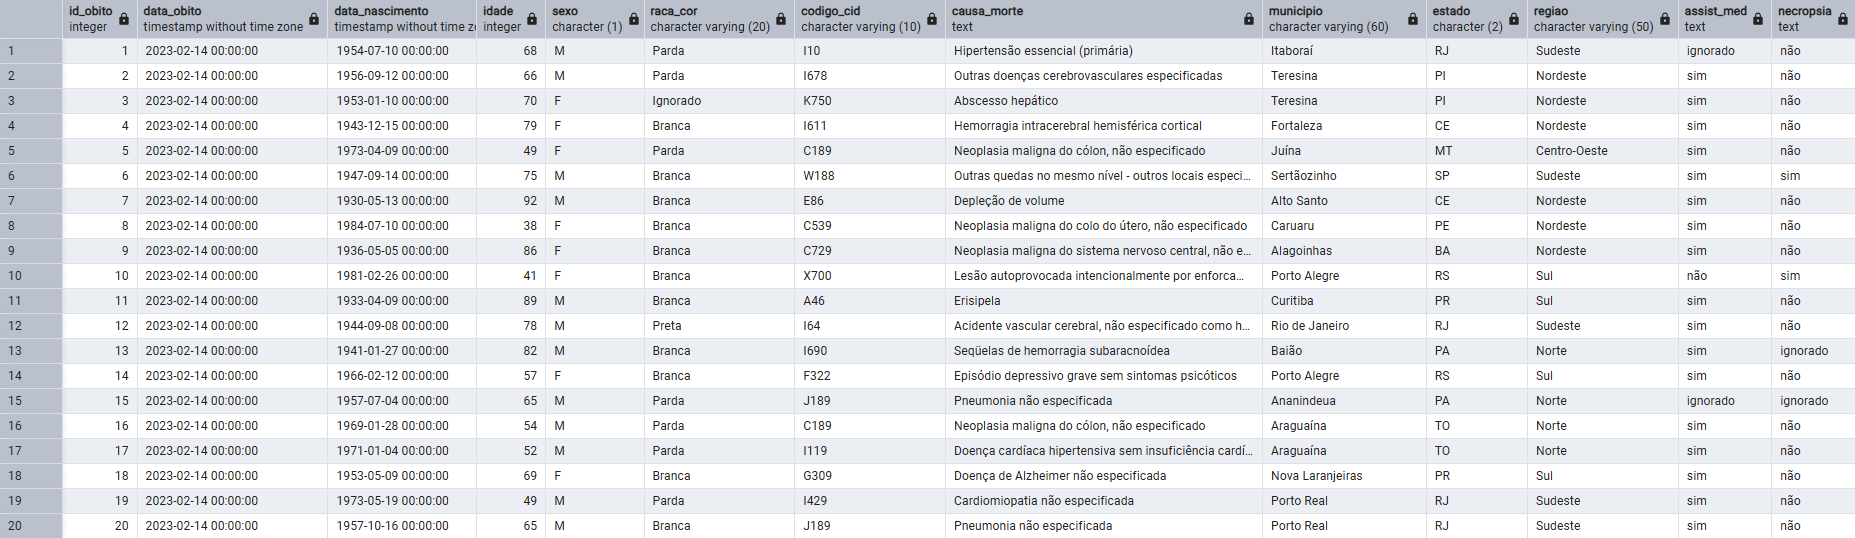

##  Procedure
### atualizar_idade_obitos

A PROCEDURE __atualizar_idade_obitos__ atualiza a idade dos óbitos sem idade (NULL), considerando a data do óbito e data de nascimento como referência para o cálculo da idade.

### Script de criação da procedure
```sql
CREATE OR REPLACE PROCEDURE atualizar_idade_obitos()
LANGUAGE plpgsql
AS $$
DECLARE
    rec RECORD;
    nova_idade INTEGER;
BEGIN
    -- Percorre todos os registros onde a idade está nula
    FOR rec IN 
        SELECT id_obito, data_nascimento, data
        FROM public.obitos 
        WHERE idade IS NULL
    LOOP
        -- Verifica se a data de nascimento e a data do óbito não são nulas
        IF rec.data_nascimento IS NOT NULL AND rec.data IS NOT NULL THEN
            -- Calcula a idade com base no ano do óbito
            nova_idade := EXTRACT(YEAR FROM AGE(rec.data, rec.data_nascimento));

            -- Verifica se a idade calculada é válida
            IF nova_idade >= 0 THEN
                UPDATE public.obitos
                SET idade = nova_idade
                WHERE id_obito = rec.id_obito;

                RAISE NOTICE 'Idade do óbito ID % atualizada para %', rec.id_obito, nova_idade;
            ELSE
                RAISE WARNING 'Óbito ID % tem uma data de nascimento inválida!', rec.id_obito;
            END IF;
        ELSE
            RAISE WARNING 'Óbito ID % não tem data de nascimento ou data de óbito, idade não pode ser calculada!', rec.id_obito;
        END IF;
    END LOOP;

    RAISE NOTICE 'Atualização de idades concluída!';
END;
$$;
```

### Execução

```sql
CALL atualizar_idade_obitos();
```

### Explicação
 - Percorre todos os óbitos sem idade (idade IS NULL) usando FOR rec IN (...) LOOP.
 - Verifica se data_nascimento e data (data do óbito) não são nulas.
 - Calcula a idade usando EXTRACT(YEAR FROM AGE(data_obito, data_nascimento)).
 - Verifica se a idade calculada é válida (>= 0) antes de atualizar.
 - Atualiza a idade no banco de dados se for um valor correto.
 - Exibe mensagens para cada caso:
   - NOTICE se a idade for atualizada corretamente.
   - WARNING se a data de nascimento ou a data do óbito for NULL ou inválida.

### Resultado

##  Trigger
### trg_auditoria_obitos
A TRIGGER __trg_auditoria_obitos__ audita as operações INSERT, UPDATE e DELETE na tabela public.obitos. Os dados da auditoria serão salvos na nova tabela chamada __auditoria__, incluindo informações sobre a operação, os dados afetados e a data/hora da mudança.

### Função: fn_auditar_obitos()
Função que será executada pela trigger
### Script:
```sql
CREATE OR REPLACE FUNCTION fn_auditar_obitos()
RETURNS TRIGGER 
LANGUAGE plpgsql
AS $$
BEGIN
    -- Auditoria de INSERT
    IF TG_OP = 'INSERT' THEN
        INSERT INTO public.auditoria (operacao, id_obito, data_nova, idade_nova, sexo_novo, data_modificacao)
        VALUES ('INSERT', NEW.id_obito, NEW.data, NEW.idade, NEW.sexo, now());

        RETURN NEW;
    END IF;

    -- Auditoria de UPDATE
    IF TG_OP = 'UPDATE' THEN
        INSERT INTO public.auditoria (operacao, id_obito, data_antiga, data_nova, idade_antiga, idade_nova, sexo_antigo, sexo_novo, data_modificacao)
        VALUES ('UPDATE', OLD.id_obito, OLD.data, NEW.data, OLD.idade, NEW.idade, OLD.sexo, NEW.sexo, now());

        RETURN NEW;
    END IF;

    -- Auditoria de DELETE
    IF TG_OP = 'DELETE' THEN
        INSERT INTO public.auditoria (operacao, id_obito, data_antiga, idade_antiga, sexo_antigo, data_modificacao)
        VALUES ('DELETE', OLD.id_obito, OLD.data, OLD.idade, OLD.sexo, now());

        RETURN OLD;
    END IF;
    
    RETURN NULL;
END;
$$;
```

### Trigger: trg_auditoria_obitos
### Script:
```sql
CREATE TRIGGER trg_auditoria_obitos
AFTER INSERT OR UPDATE OR DELETE
ON public.obitos
FOR EACH ROW
EXECUTE FUNCTION fn_auditar_obitos();
```

# Consultas SQL

Abaixo estão cinco consultas SQL explorando os dados do banco:

## 1. Municípios com mais óbitos por estado
### Script:
```sql
WITH obitos_por_municipio AS (
    SELECT 
        l.estado,
        l.municipio,
        COUNT(o.id_obito) AS total_obitos,
        RANK() OVER (PARTITION BY l.estado ORDER BY COUNT(o.id_obito) DESC) AS rank
    FROM public.obitos o
    JOIN public.localizacoes l ON o.id_local = l.id_local
    GROUP BY l.estado, l.municipio
)
SELECT estado, municipio, total_obitos
FROM obitos_por_municipio
WHERE rank = 1
ORDER BY total_obitos DESC;
```

### Explicação:
1. Conta o total de óbitos por município e estado, agrupando os registros.
2. Usa a função RANK() para classificar os municípios dentro de cada estado, ordenando do maior para o menor número de óbitos.
3. Filtra apenas os municípios com maior número de óbitos em cada estado (rank = 1), garantindo um único resultado por estado.

### Resultado:
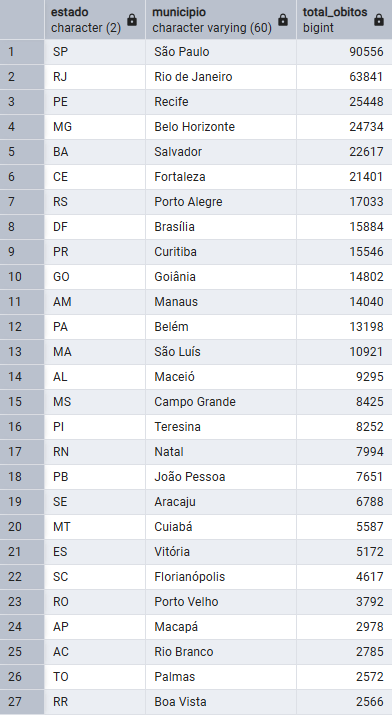

## 2. Principal causa de morte por faixa etária
### Script:
```sql
WITH obitos_faixa_etaria AS (
    SELECT 
        CASE 
            WHEN o.idade BETWEEN 0 AND 10 THEN '0 a 10 anos'
            WHEN o.idade BETWEEN 11 AND 30 THEN '11 a 30 anos'
            WHEN o.idade BETWEEN 31 AND 50 THEN '31 a 50 anos'
            WHEN o.idade BETWEEN 51 AND 70 THEN '51 a 70 anos'
            WHEN o.idade > 71 THEN 'Maior que 71 anos'
        END AS faixa_etaria,
        o.id_causa_principal,
        c.codigo_cid,
        c.descricao,
        COUNT(o.id_obito) AS total_obitos
    FROM public.obitos o
    JOIN public.causas c ON o.id_causa_principal = c.id_causa
    WHERE o.idade IS NOT NULL
    GROUP BY faixa_etaria, o.id_causa_principal, c.codigo_cid, c.descricao
),
ranking_causas AS (
    SELECT *,
        RANK() OVER (PARTITION BY faixa_etaria ORDER BY total_obitos DESC) AS rank
    FROM obitos_faixa_etaria
)
SELECT id_causa_principal, codigo_cid, descricao, faixa_etaria, total_obitos
FROM ranking_causas
WHERE rank = 1
ORDER BY faixa_etaria;
```

### Explicação:
1. Subconsulta __obitos_faixa_etaria__:
   - Classifica os óbitos em faixas etárias.
   - Conta o total de óbitos por faixa etária e id_causa_principal.
   - Associa cada óbito à tabela causas para obter o codigo_cid e a descricao.
   - Filtra apenas os registros com idade preenchida (WHERE o.idade IS NOT NULL).
2. Subconsulta __ranking_causas__:
   - Usa a função RANK() para classificar as causas dentro de cada faixa etária com base no total de óbitos.
3. Seleciona apenas a principal causa de óbitos para cada faixa etária (WHERE rank = 1), garantindo que só apareça a causa com mais ocorrências por faixa.
4. Ordena o resultado por faixa etária, para facilitar a visualização.

### Resultado:
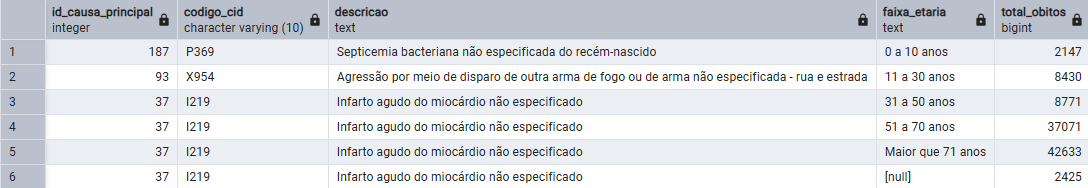

## 3. As 10 principais causas de óbito, com a idade média das vítimas
### Script:
```sql
SELECT c.codigo_cid, c.descricao, ROUND(AVG(o.idade), 1) AS idade_media, COUNT(o.id_obito) AS total_obitos
FROM obitos o
JOIN causas c ON o.id_causa_principal = c.id_causa
WHERE o.idade > 0
GROUP BY c.codigo_cid, c.descricao
ORDER BY total_obitos DESC
LIMIT 10;
```

### Explicação:
1. Calcula a idade média das vítimas (AVG(o.idade), arredondado com ROUND(,1)).
2. Conta o total de óbitos por causa (COUNT(o.id_obito)).
3. Relaciona os óbitos às causas (JOIN entre obitos e causas).
4. Agrupa os dados por causa de morte (GROUP BY c.codigo_cid, c.descricao).
5. Ordena pelos estados com mais óbitos (ORDER BY total_obitos DESC).
6. Mostra apenas as 10 principais causas (LIMIT 10).

### Resultado:
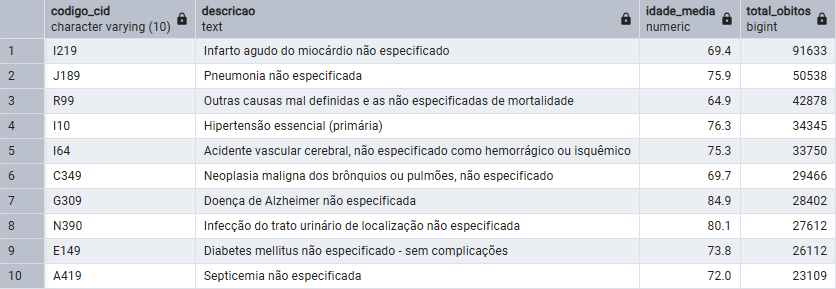

## 4. Principal causa de morte para homens e mulheres por região

### Script:
```sql
WITH obitos_por_regiao_sexo AS (
    SELECT 
        l.regiao,
        o.sexo,
        o.id_causa_principal,
        c.codigo_cid,
        c.descricao,
        COUNT(o.id_obito) AS total_obitos
    FROM public.obitos o
    JOIN public.localizacoes l ON o.id_local = l.id_local
    JOIN public.causas c ON o.id_causa_principal = c.id_causa
    WHERE o.sexo IN ('M', 'F')  -- Filtra apenas óbitos de homens e mulheres
    GROUP BY l.regiao, o.sexo, o.id_causa_principal, c.codigo_cid, c.descricao
),
ranked_causas AS (
    SELECT *,
        RANK() OVER (PARTITION BY regiao, sexo ORDER BY total_obitos DESC) AS rank
    FROM obitos_por_regiao_sexo
)
SELECT regiao, sexo, codigo_cid, descricao, total_obitos
FROM ranked_causas
WHERE rank = 1
ORDER BY regiao, sexo;
```

### Explicação:
1. Subconsulta (obitos_por_regiao_sexo):
   - Agrupa os óbitos por região, sexo (homem ou mulher) e causa principal.
   - Para cada grupo (por região e sexo), conta o total de óbitos e traz o código CID e descrição da causa.
   - Utiliza JOINs para associar as tabelas obitos, localizacoes e causas.
2. Subconsulta (ranked_causas):
   - A função RANK() é usada para ordenar as causas de óbito dentro de cada região e sexo, do maior para o menor número de óbitos.
   - Isso garante que a principal causa de óbito (com maior número de óbitos) receba o rank 1.
Filtragem:
3. Seleciona apenas os registros com rank = 1, ou seja, a principal causa de óbito em cada região para cada sexo.
Ordenação:
4. Os resultados são ordenados por região e sexo, para facilitar a leitura.

### Resultado:
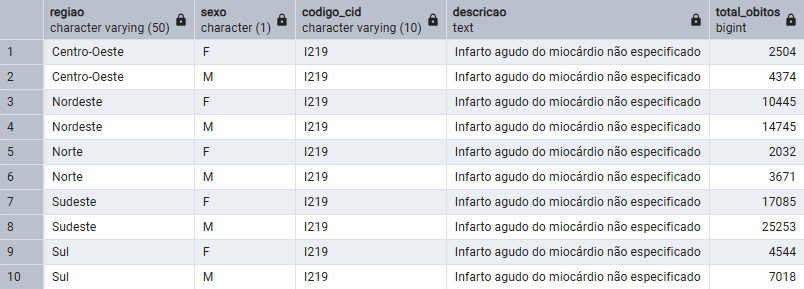

## 5. Municípios com mais óbitos sem necropsia
### Script:
```sql
SELECT 
    l.municipio,
    l.estado,
    COUNT(o.id_obito) AS total_obitos_sem_necropsia
FROM public.obitos o
JOIN public.localizacoes l ON o.id_local = l.id_local
WHERE o.necropsia IS NULL OR o.necropsia = 'não'
GROUP BY l.municipio, l.estado
ORDER BY total_obitos_sem_necropsia DESC
LIMIT 10;
```

### Explicação
1. JOIN public.localizacoes l ON o.id_local = l.id_local:
   - Realiza o JOIN entre as tabelas obitos e localizacoes para relacionar o óbito com o município e estado.
2. WHERE o.necropsia IS NULL OR o.necropsia = '':
   - Filtra os óbitos onde não há necropsia registrada (campo necropsia é nulo ou vazio).
3. COUNT(o.id_obito) AS total_obitos_sem_necropsia:
   - Conta o número total de óbitos sem necropsia para cada município.
4. GROUP BY l.municipio, l.estado:
   - Agrupa os resultados por município e estado, para contabilizar os óbitos de cada local.
5. ORDER BY total_obitos_sem_necropsia DESC:
   - Ordena os municípios de maior para menor número de óbitos sem necropsia.

### Resultado:
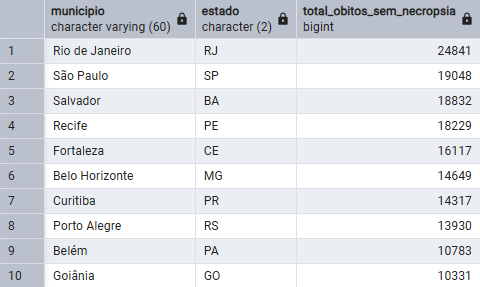

# Consultas em Álgebra Relacional

##  Quantidade de Óbitos por Município (TOP 10)

$$
\pi_{\text{municipio}, \text{total\_obitos}} \left( \sigma_{\text{total\_obitos} \geq 10} \left( \gamma_{\text{municipio}}^{\text{COUNT}(id\_obito) \rightarrow \text{total\_obitos}} \left( \text{Obitos} \bowtie_{\text{Obitos.id\_local} = \text{Localizacoes.id\_local}} \text{Localizacoes} \right) \right) \right)
$$

### **Explicação**:
- **\(⨝\)** → Junção entre **Óbitos** e **Localizações** baseada no `id_local`.
- **\(γ\)** → Agrupa por município e conta o número de óbitos.
- **\(σ\)** → Filtra municípios com pelo menos **10 óbitos**.
- **\(π\)** → Retorna apenas as colunas **município** e **total_obitos**.

---

## CID com Maior Número de Mortes

$$
\pi_{\text{codigo\_cid}, \text{descricao}, \text{total\_obitos}} \left( \sigma_{\text{total\_obitos} = \max(\text{total\_obitos})} \left( \gamma_{\text{codigo\_cid}, \text{descricao}}^{\text{COUNT}(id\_obito) \rightarrow \text{total\_obitos}} \left( \text{Obitos} \bowtie_{\text{Obitos.id\_causa\_principal} = \text{Causas.id\_causa}} \text{Causas} \right) \right) \right)
$$

###  **Explicação**:
- **\(⨝\)** → Junção entre **Óbitos** e **Causas** baseada no `id_causa`.
- **\(γ\)** → Agrupa por **CID** e conta o número de óbitos.
- **\(σ\)** → Filtra apenas o CID com **maior número de mortes**.
- **\(π\)** → Retorna **código CID**, **descrição** e **total de óbitos**.

---

## Média de Idade dos Falecidos por Região

$$
\pi_{\text{regiao}, \text{media\_idade}} \left( \gamma_{\text{regiao}}^{\text{AVG}(idade) \rightarrow \text{media\_idade}} \left( \text{Obitos} \bowtie_{\text{Obitos.id\_local} = \text{Localizacoes.id\_local}} \text{Localizacoes} \right) \right)
$$

### **Explicação**:
- **\(⨝\)** → Junção entre **Óbitos** e **Localizações** baseada no `id_local`.
- **\(γ\)** → Agrupa por **região** e calcula a média da idade.
- **\(π\)** → Retorna apenas as colunas **região** e **média de idade**.

---

 Notação formal de **Álgebra Relacional**:
- **Seleção** \(σ\)
- **Projeção** \(π\)
- **Junção** \(⨝\)
- **Agregação** \(γ\)


